In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from utils import *

plt.style.use('ggplot')

## Data loading

,Kilopris (kr),Vekt (tonn),Year,Week,Month,Day of year,log_returns
uke,,,,,,,
2000-01-10,31.12,4054,2000,2,1,10,NaN
2000-01-17,31.03,4043,2000,3,1,17,-0.002717
2000-01-24,30.95,3730,2000,4,1,24,-0.080579
2000-01-31,31.30,3831,2000,5,1,31,0.026718
2000-02-07,32.53,4415,2000,6,2,38,0.141882
...,...,...,...,...,...,...,...
2023-07-24,86.14,19604,2023,30,7,205,0.091045
2023-07-31,83.28,20469,2023,31,7,212,0.043178
2023-08-07,80.26,21060,2023,32,8,219,0.028464


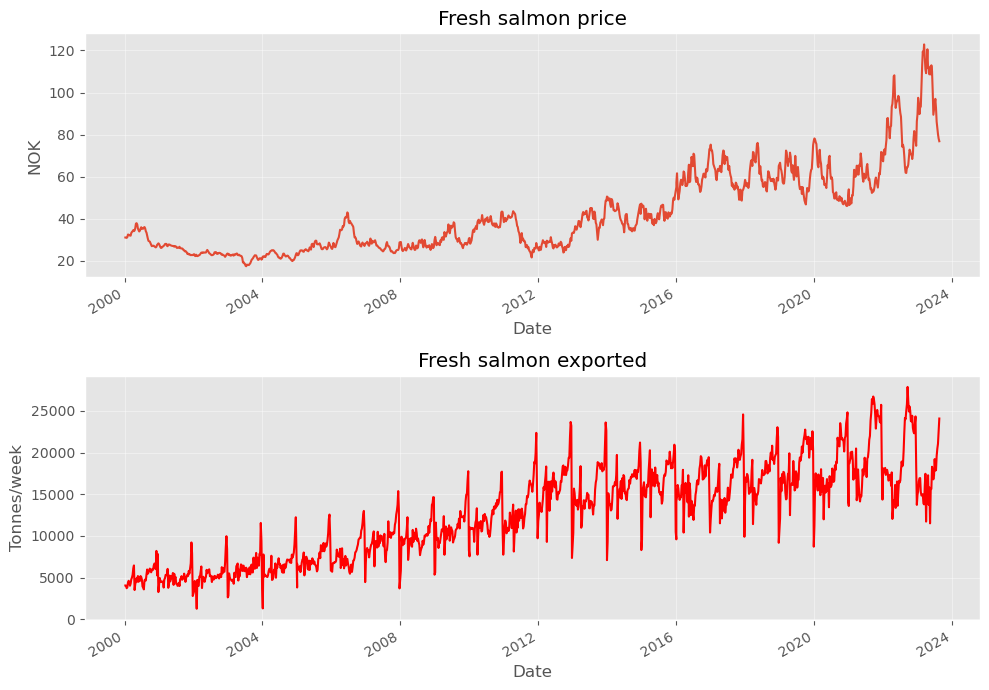

In [2]:
data_URL = 'https://www.ssb.no/statbank/sq/10085910'

data = import_salmon_data(data_URL)

add_lags(data)

data['log_returns'] = np.log(data['Vekt (tonn)']/data['Vekt (tonn)'].shift())
display(data)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 7))

data['Kilopris (kr)'].plot(ax=ax1, ylabel='NOK')
data['Vekt (tonn)'].plot(ax=ax2, color='red', ylabel='Tonnes/week')
ax1.set_title('Fresh salmon price')
ax2.set_title('Fresh salmon exported')
ax1.grid(alpha=0.4); ax2.grid(alpha=0.4)
ax1.set_xlabel('Date'); ax2.set_xlabel('Date')
fig.tight_layout()

## Data analysis

,Kilopris (kr),Vekt (tonn),Year,Week,Month,Day of year,log_returns
uke,,,,,,,
2000-01-10,31.12,4054,2000,2,1,10,NaN
2000-01-17,31.03,4043,2000,3,1,17,-0.002717
2000-01-24,30.95,3730,2000,4,1,24,-0.080579
2000-01-31,31.30,3831,2000,5,1,31,0.026718
2000-02-07,32.53,4415,2000,6,2,38,0.141882
...,...,...,...,...,...,...,...
2023-07-24,86.14,19604,2023,30,7,205,0.091045
2023-07-31,83.28,20469,2023,31,7,212,0.043178
2023-08-07,80.26,21060,2023,32,8,219,0.028464


[]

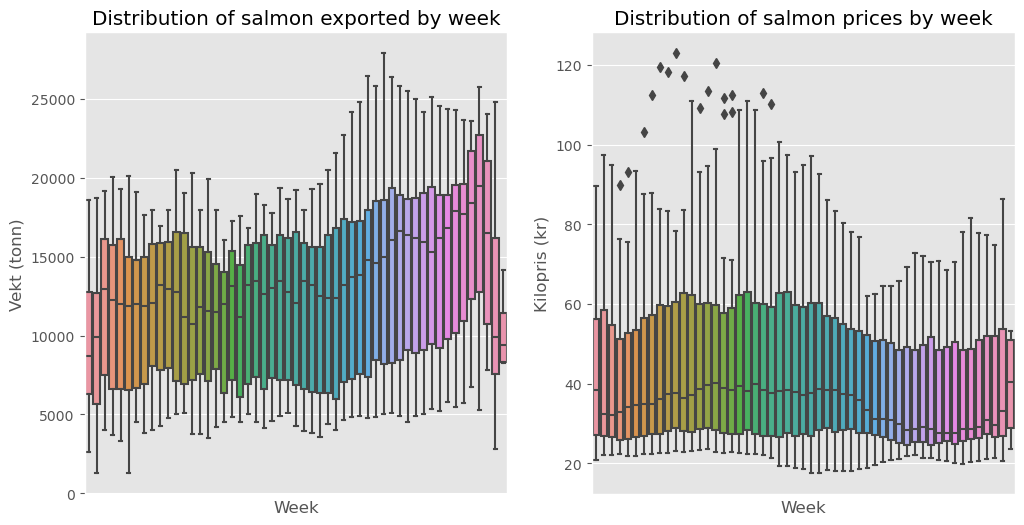

In [3]:
display(data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data=data, x='Week', y='Vekt (tonn)', ax=ax1)
sns.boxplot(data=data, x='Week', y='Kilopris (kr)', ax=ax2)
ax1.set_title('Distribution of salmon exported by week')
ax2.set_title('Distribution of salmon prices by week')
ax1.set_xticks([])
ax2.set_xticks([])

## Model training

In [4]:

tscv = TimeSeriesSplit(n_splits=7)

features = ['Year', 'Week', 'Month', 'Day of year']
targets = ['Vekt (tonn)', 'Kilopris (kr)']

reg_model = xgb.XGBRegressor(n_estimators=10000, early_stopping_rounds=1000)

# Iterate over the time series splits
for train_index, test_index in tscv.split(data):
    X_train, X_test = data[features].iloc[train_index], data[features].iloc[test_index]
    y_train, y_test = data[targets].iloc[train_index], data[targets].iloc[test_index]

    # Fit the XGBoost model
    reg_model.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False
    )

    # Make predictions
    y_pred = reg_model.predict(X_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")


Mean Squared Error: 1657918.6435
Mean Squared Error: 2470550.4886
Mean Squared Error: 4686693.5391
Mean Squared Error: 6177922.8627
Mean Squared Error: 1624659.0224
Mean Squared Error: 2478345.6628
Mean Squared Error: 4037109.6977


## Model prediction

,Importance
Year,0.669898
Week,0.204769
Month,0.083588
Day of year,0.041746


,Date,Year,Week,Month,Day of year
Date,,,,,
2023-08-21,2023-08-21,2023,34,8,233
2023-08-22,2023-08-22,2023,34,8,234
2023-08-23,2023-08-23,2023,34,8,235
2023-08-24,2023-08-24,2023,34,8,236
2023-08-25,2023-08-25,2023,34,8,237
...,...,...,...,...,...
2025-12-20,2025-12-20,2025,51,12,354
2025-12-21,2025-12-21,2025,51,12,355
2025-12-22,2025-12-22,2025,52,12,356


Week 43:


,2023-10-23
Vekt (tonn),20997.248047
Kilopris (kr),50.680431


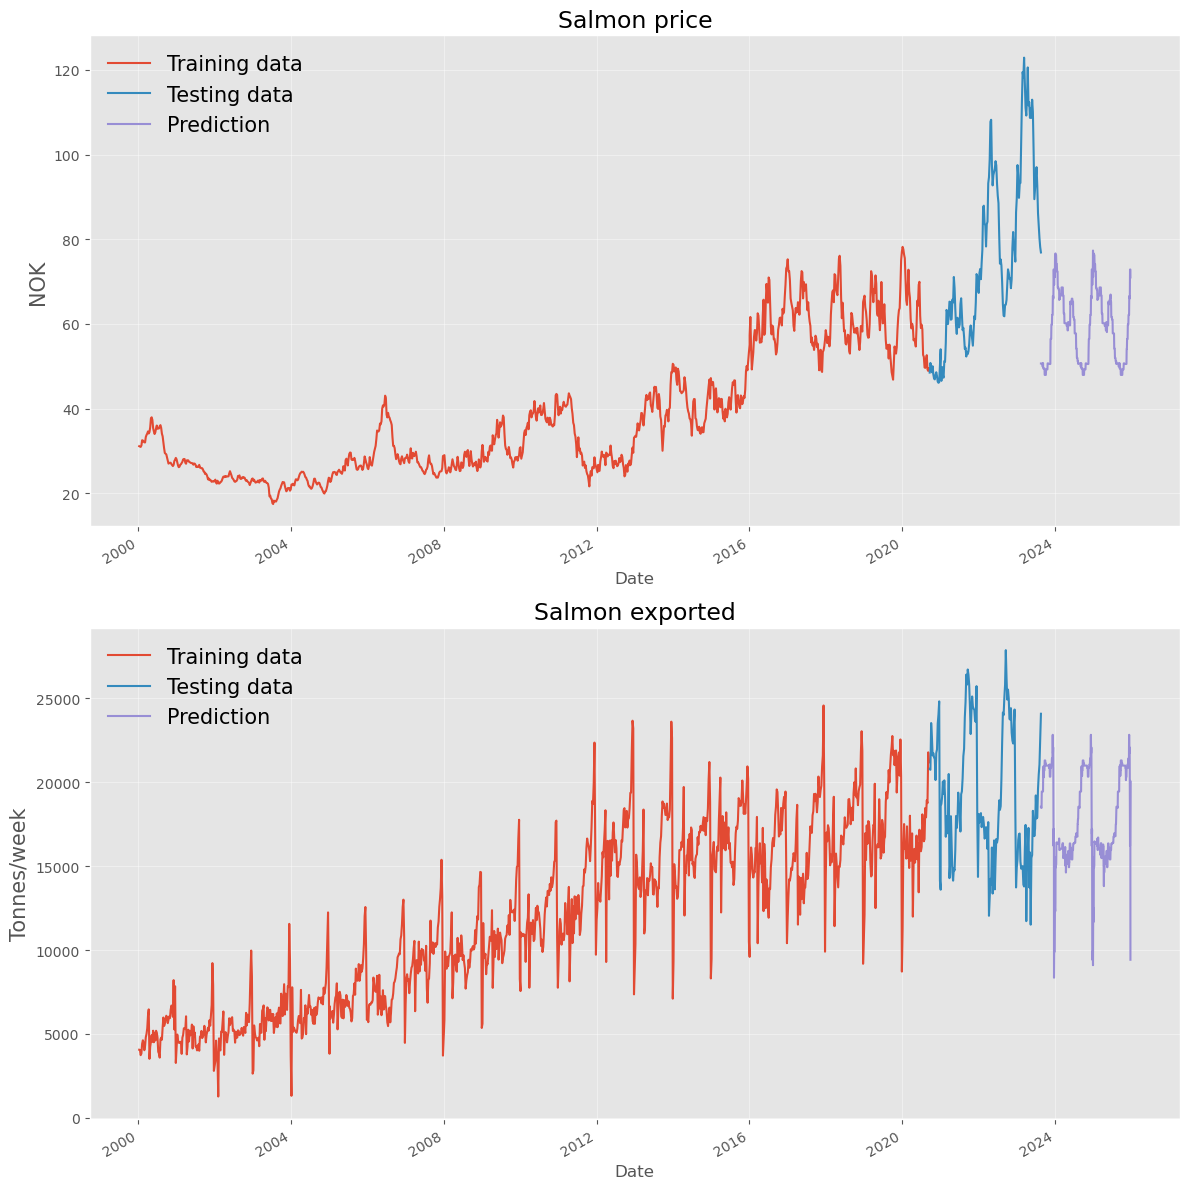

In [5]:
fi = pd.DataFrame(data=reg_model.feature_importances_, index=reg_model.feature_names_in_, columns=['Importance'])
display(fi)

future_dates = pd.DataFrame(
    pd.date_range(
        start=data.index[-1], 
        end='2025-12-24'
    ), columns=['Date']
)

future_dates.set_index(future_dates['Date'], inplace=True)
add_lags(future_dates)

display(future_dates)

future_dates.drop('Date', axis=1, inplace=True)

predictions = pd.DataFrame(reg_model.predict(future_dates), columns=targets, index=future_dates.index)

fig, axs = plt.subplots(2, figsize=(12, 12))

data_types = ['Training data', 'Testing data', 'Prediction']
label = ['NOK', 'Tonnes/week']
title = ['Salmon price', 'Salmon exported']

for i, target in enumerate(['Kilopris (kr)', 'Vekt (tonn)']):
    for j, data in enumerate([y_train, y_test, predictions]):
        data[target].plot(ax=axs[i], label=data_types[j])
        axs[i].legend(fontsize=15, frameon=False)
        axs[i].grid(alpha=0.4)
        axs[i].set_ylabel(label[i], fontsize=15)
        axs[i].set_title(title[i], fontsize=17)

fig.tight_layout()

# Week 43:
print('Week 43:')
display(pd.DataFrame(predictions.loc['2023-10-23']))